In [ ]:
%load_ext autoreload
%autoreload 2

Mapping the surfaces into the dataset of men points:

In [ ]:
import pandas as pd

df_men = pd.read_csv('../points_datasets/charting-m-points-2020s.csv', low_memory=False)
len(df_men)

Extracting the players names from the column 'match_id':

In [ ]:
# Estrai i nomi dei giocatori dalla colonna 'match_id'
players = df_men['match_id'].str.extract(r'(\w+_\w+)-(\w+_\w+)')

# Combina i nomi dei giocatori in un unico elenco con la superficie
df_men['player_1'] = players[0]
df_men['player_2'] = players[1]

# Riorganizza i dati per avere un'unica colonna con i nomi dei giocatori e le superfici
player_surface = pd.concat([
    df_men[['player_1', 'surface']].rename(columns={'player_1': 'player'}),
    df_men[['player_2', 'surface']].rename(columns={'player_2': 'player'})
])

# crea un dizionario con i nomi dei giocatori come chiave e le superfici su cui ha giocato almeno una volte come valore
# Crea un dizionario con i nomi dei giocatori come chiave e le superfici come valore
player_surface_dict = player_surface.groupby('player')['surface'].apply(set).to_dict()

# Stampa il dizionario risultante
print(player_surface_dict)


In [ ]:
df_men

Total number of matches:


In [ ]:
len(df_men['match_id'].unique())

Sinner points:

In [ ]:
sinner = df_men[df_men['match_id'].str.contains(r'Jannik_Sinner')]

Zverev points:

In [ ]:
zverev = df_men[df_men['match_id'].str.contains(r'Alexander_Zverev')]
zverev

Alcaraz points:

In [ ]:
alcaraz = df_men[df_men['match_id'].str.contains(r'Carlos_Alcaraz')]
alcaraz

Djokovic points:

In [ ]:
djokovic = df_men[df_men['match_id'].str.contains(r'Novak_Djokovic')]

Fritz points:

In [ ]:
fritz = df_men[df_men['match_id'].str.contains(r'Taylor_Fritz')]

Mean of the points number of the five players:

In [ ]:
points_mean = (len(sinner) + len(zverev) + len(alcaraz) + len(djokovic) + len(fritz)) / 5
points_mean

Mean of the matches analyzed by player:

In [ ]:
average_match_number = (len(sinner['match_id'].unique()) + len(zverev['match_id'].unique()) + len(
    alcaraz['match_id'].unique()) + len(djokovic['match_id'].unique()) + len(fritz['match_id'].unique())) / 5
average_match_number

Dataframe of women:

In [ ]:
df_women = pd.read_csv('../points_datasets/charting-w-points-2020s.csv', low_memory=False)
df_women

Extracting the woment players names from the column 'match_id':

In [ ]:
# Estrai i nomi dei giocatori dalla colonna 'match_id'
players = df_women['match_id'].str.extract(r'(\w+_\w+)-(\w+_\w+)')

# Combina i nomi dei giocatori in un unico elenco
all_players = pd.concat([players[0], players[1]]).unique()

# Ordina i nomi in ordine alfabetico
all_players = sorted(all_players)

# Stampa o salva i nomi dei giocatori
print(all_players)
print(len(all_players))

Total number of matches:


In [ ]:
len(df_women['match_id'].unique())

Sabalenka points:


In [ ]:
sabalenka = df_women[df_women['match_id'].str.contains(r'Aryna_Sabalenka')]
sabalenka

Swiatek points:

In [ ]:
swiatek = df_women[df_women['match_id'].str.contains(r'Iga_Swiatek')]
swiatek

Gauff points:

In [ ]:
gauff = df_women[df_women['match_id'].str.contains(r'Coco_Gauff')]
gauff

Pegula points

In [ ]:
pegula = df_women[df_women['match_id'].str.contains(r'Jessica_Pegula')]
pegula

Keys points:

In [ ]:
keys = df_women[df_women['match_id'].str.contains(r'Madison_Keys')]
keys

Mean of the point of the five players:

In [ ]:
points_mean = (len(sabalenka) + len(swiatek) + len(gauff) + len(pegula) + len(keys)) / 5
points_mean

Mean of the matches analyzed by player:


In [ ]:
average_match_number = (len(sabalenka['match_id'].unique()) + len(swiatek['match_id'].unique()) + len(
    gauff['match_id'].unique()) + len(pegula['match_id'].unique()) + len(keys['match_id'].unique())) / 5
average_match_number

First clustering test, with kmeans and dbscan on the specific context: vary low variance, no relevant clusters are detected.
✅ Perché la varianza è bassa nel tuo caso
Stai analizzando comportamenti in contesti molto specifici (es. "1st serve su terra").

In questi contesti, le strategie sono naturalmente simili tra giocatori: tutti affrontano condizioni e dinamiche simili.

Quindi è normale che le feature (rate di slice, vincenti, lunghezza media degli scambi, ecc.) abbiano variazioni minime, da cui una PCA schiacciata e clustering difficile.

🧭 Strategia: allargare progressivamente il contesto
Ottima idea. Puoi procedere così:

1. Contesto medio-specializzato
Es. "tutti i punti al servizio su terra", unendo 1st e 2nd.

2. Contesto più ampio
Es. "tutti i punti al servizio" indipendentemente dalla superficie.

3. Contesto generale
Tutti i colpi del giocatore, aggregando tutto (serve/response, superfici).

🎯 Obiettivo finale:
Capire a che livello di granularità emergono:

differenze significative tra stili (più cluster distinti, silhouette score alto)

oppure confermare che alcuni contesti sono intrinsecamente “uniformanti” (→ bassa varianza, stile unico richiesto).

Loading dataset:

In [ ]:
import pandas as pd
df = pd.read_csv('../feature_datasets_csv/on response with the 1st_ on clay.csv', low_memory=False)

I'm trying to merge 2 datasets, on resp. with the 1st on clay and with the 2nd.


In [ ]:
import pandas as pd
df1 = pd.read_csv('../feature_datasets_csv/on response with the 1st_ on clay.csv', low_memory=False)
df2 = pd.read_csv('../feature_datasets_csv/on response with the 2nd_ on clay.csv', low_memory=False)
df_concat=pd.concat([df1, df2])

Hard datasets:

In [ ]:
import pandas as pd
df_hard=pd.read_csv('../feature_datasets_csv/on response with the 2nd_ on hard.csv', low_memory=False)

Hard dataset, on serve:

In [ ]:
df_hard_serve=pd.read_csv('../feature_datasets_csv_reduced_contexts/on serve_ on hard.csv', low_memory=False)

Correlation matrix:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_hard.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.show()

Running clustering:

In [ ]:
from run_clustering import *
import pandas as pd

# prova kmeans con vari k, stampando i silhouette scores
# decente ma meglio agglomerative
#run_kmeans_clustering(df_hard_serve)

#male
#run_dbscan_clustering(df_hard)

#gmm: risultati strani, appartenenza alta ma in optics tanto rumore... bah
#for k in range(2, 4):
#    run_umap_gmm_clustering(df_hard_serve,None,k,15,0.1,0.9,True) #todo: capire perche gmm ha max_probs altissime ma silhouette sempre basso
df_clustered=run_umap_agglomerative_clustering(df_hard_serve, None, 3, 2, 'complete', True)

#problema di optics: troppi punti di rumore, troppi giocatori rimangono esclusi
for min_pts in range(4, 11):
   for xi in np.arange(start=0.04, stop=0.12, step=0.01):
      df_clustering = run_umap_optics_clustering(df_hard, min_pts=min_pts, xi=xi,min_cluster_size=0.1)
#run_umap_optics_clustering(df_hard_serve, 'umap', None, 8, 0.08, 0.1, True)


print("Righe: ",df_hard.shape[0], "colonne: ", df_hard.shape[1])

Uploading of all the datasets:

In [ ]:
import os
import pandas as pd

dfs=[]
features_dataset_dir = '../feature_datasets_csv_reduced_contexts&features/'

# Itera su tutti i file nella cartella specificata
for dataset_name in os.listdir(features_dataset_dir):
    # Controlla se il file è un CSV
    if dataset_name.endswith('.csv'):
        # Costruisci il percorso completo del file
        file_path = os.path.join(features_dataset_dir, dataset_name)
        # Carica il dataset
        dfs.append((dataset_name,pd.read_csv(file_path, low_memory=False)))

UMAP does not preserve the convexity structure.

KMeans clustering:

In [ ]:
from run_clustering import *

dfs_clustered = []

for name, dataframe in dfs:
    print(name)
    for umap_comp in range(2, 3):
        metrics = []
        df_clustered, silhouette_score, dbi=run_kmeans_clustering(dataframe, 4, True, umap_comp)
        dfs_clustered.append((name,df_clustered))
        metrics.append((silhouette_score,dbi,umap_comp))
    print({name: max(metrics, key = lambda x: x[0])})


Agglomerative clustering:

In [ ]:
from run_clustering import *

for name, dataframe in dfs:
    print(name)
    for umap_comp in range(2, 11):
        silhouette_scores = []
        df_clustered, silhouette_score=run_umap_agglomerative_clustering(dataframe, None, 4, umap_comp, 'complete', False)
        silhouette_scores.append((silhouette_score,umap_comp))
    print({name: max(silhouette_scores, key = lambda x: x[1])})

Optics reachability plot:

In [ ]:
from run_clustering import *

for name, dataframe in dfs:
    print(name)
    for min_pts in range(6, 11):
        for xi in np.arange(start=0.06, stop=0.12, step=0.01):
            df_clustering = run_umap_optics_clustering(dataframe, min_pts=min_pts, xi=xi)

GMM cluster:

In [ ]:
from run_clustering import run_umap_gmm_clustering
for name, dataframe in dfs:
    print(name)
    for k in range(4, 5):
        run_umap_gmm_clustering(dataframe,None,k,15,0.1,0.9,True)


Agglomerate statistic by cluster visualization:

In [ ]:
from visualize_results import cluster_feature_deltas
from visualize_results import aggregate_features_by_cluster
import seaborn as sns
import matplotlib.pyplot as plt
# todo: visualizzare i cluster
# stampa le features aggregate per cluster
aggregated = aggregate_features_by_cluster(df_clustered)
print(aggregated)

# stampa la hitmap della differenza nelle statistiche tra i clusters e la media globale
sns.heatmap(cluster_feature_deltas(df_clustered), annot=True, cmap='coolwarm')
plt.title("Scostamenti medi delle feature per cluster")
plt.show()


Calculate for each context, for each cluster, the top n representative features, i.e. the ones that have the highest difference between the cluster centroid feature and the overall feature mean.

In [ ]:
from visualize_results import analyze_cluster_profiles

for name, df_clustered in dfs_clustered:
    print(name)
    if "on serve" in name:
        context = "on serve"
    else:
        context = "on response"
    analyze_cluster_profiles(df_clustered, point_context=context)

Visualize similarity matrix and heatmap. The similarity matrix calculate the distance between each cluster in a context with each other cluster in different context. For each cluster, the 3 most similar clusters in each the 3 surfaces represent the same style

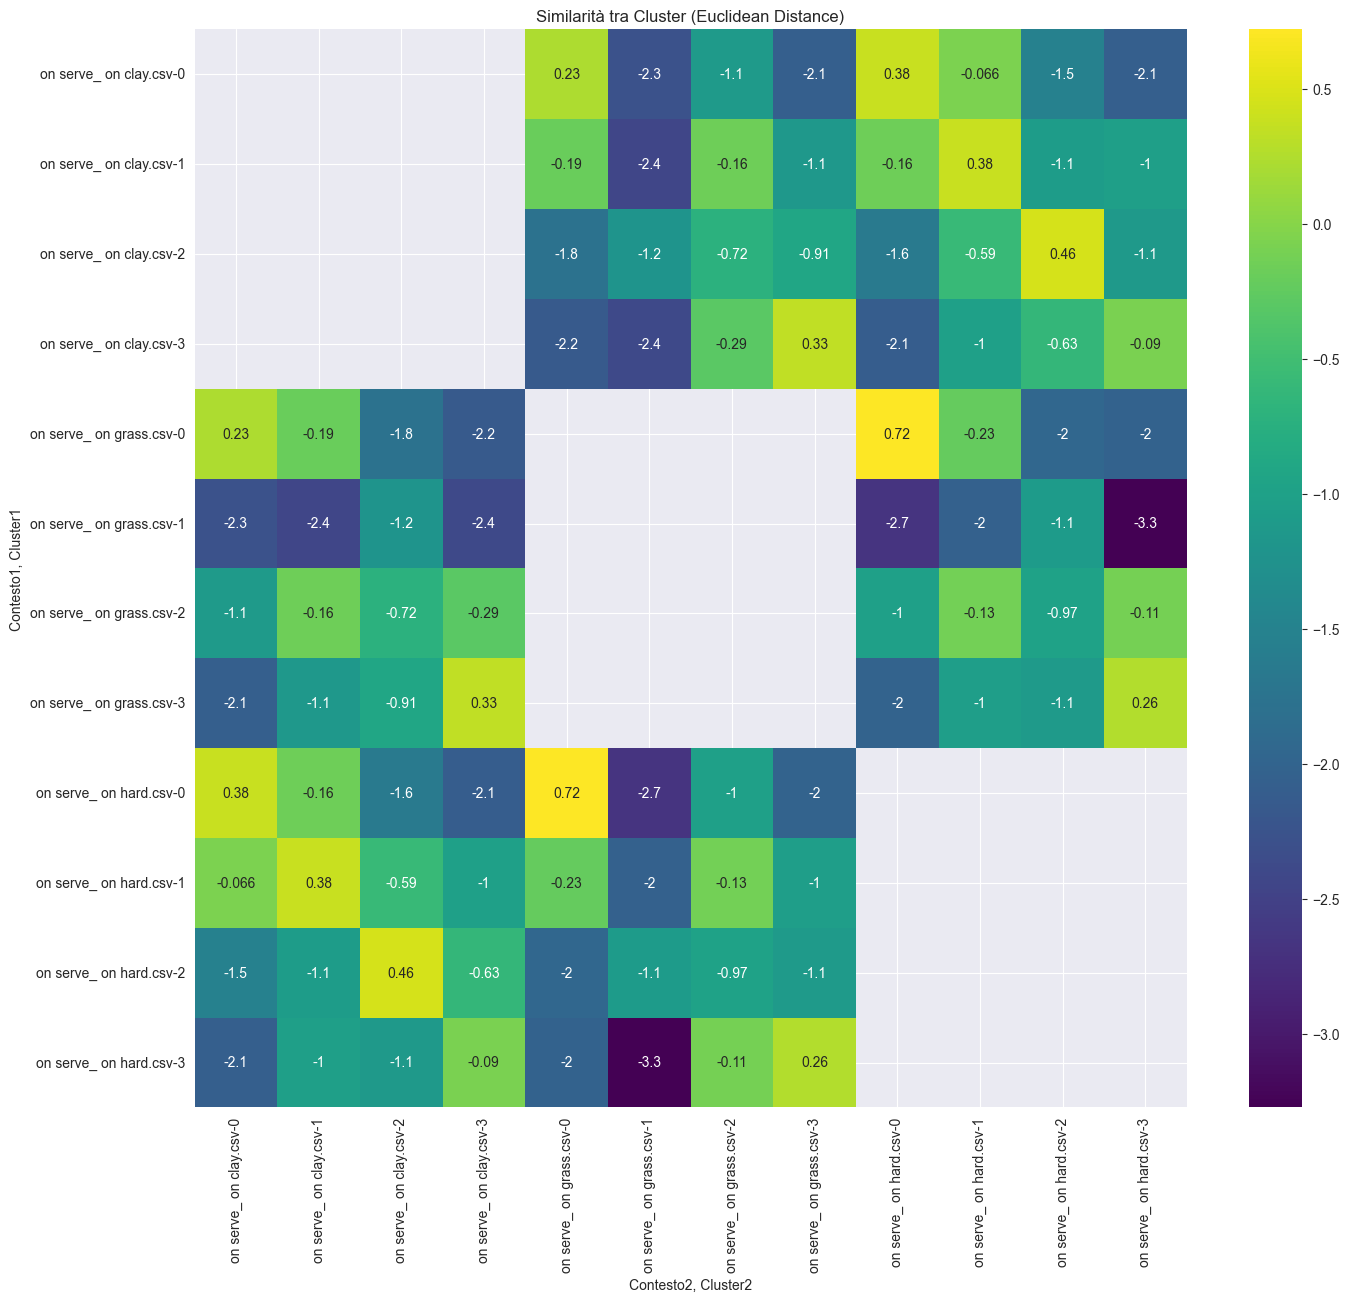

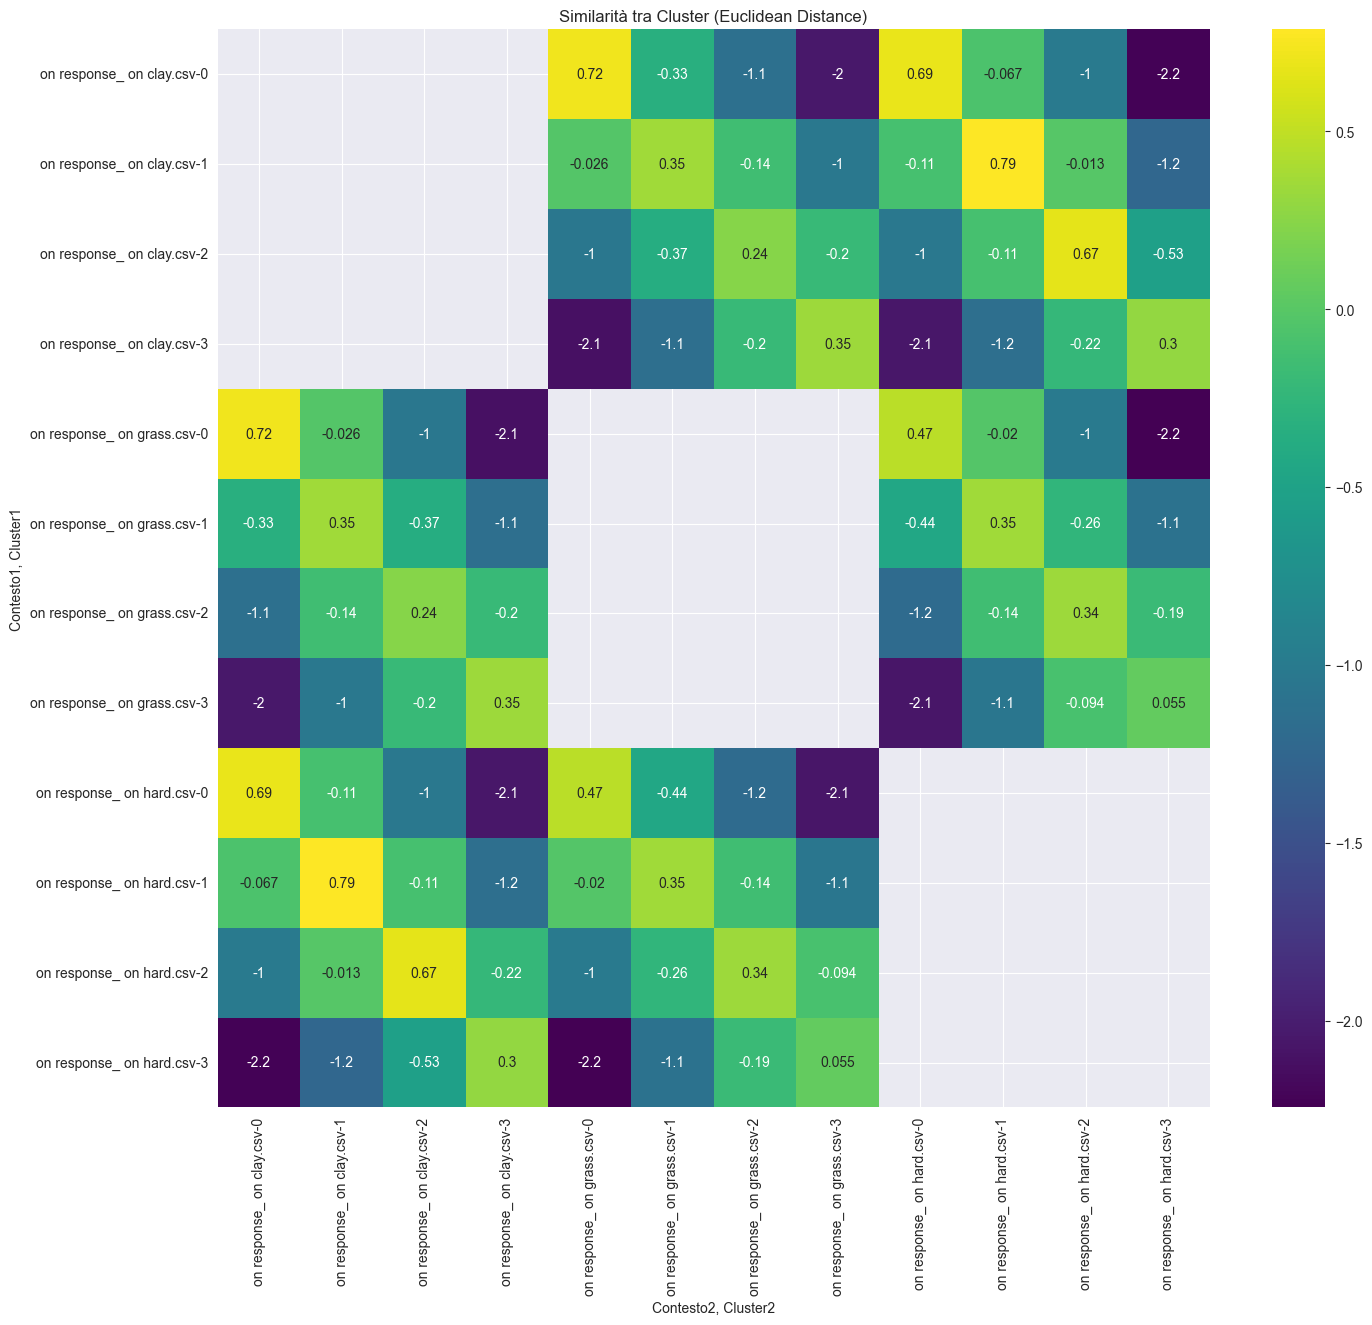

In [13]:
from visualize_results import calculate_centroid_similarity, visualize_similarity_matrix
# 3. Calcolo della Similarità tra Centroidi
clustered_data_on_serve = []
clustered_data_on_response = []
for context, df_clustered in dfs_clustered:
    if "on serve" in context:
        clustered_data_on_serve.append((context, df_clustered))
    else:
        clustered_data_on_response.append((context, df_clustered))
similarity_df_on_serve = calculate_centroid_similarity(clustered_data_on_serve)
similarity_df_on_response = calculate_centroid_similarity(clustered_data_on_response)

# 4. Visualizzazione della Matrice di Similarità
visualize_similarity_matrix(similarity_df_on_serve, clustered_data_on_serve)
visualize_similarity_matrix(similarity_df_on_response, clustered_data_on_response)
#todo: per ogni cluster di un contesto, raggrupparlo insieme ai cluster più simili di un altro contesto e assegnargli il nome di uno stile. Di seguito, una volta tracciato l'andamento del giocatore nei diversi contesti, verificare se un giocatore cambia cluster a seconda del contesto

Variance visualization and hopkins statistic. A 0.75 Hopkins stat indicates clustering tendency with a 90% confidence level.

In [ ]:
from sklearn.preprocessing import StandardScaler
from run_clustering import hopkins
for name, dataframe in dfs:
    print(name)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(dataframe.values)
    dataframe.var().sort_values()
    mean, std_dev, values = hopkins(X_scaled)
    print(f"Hopkins statistic (df): {mean:.3f} ± {std_dev:.3f}\n")



Variance explained after PCA:

In [ ]:
from run_clustering import explained_variance_from_features

explained_variance_from_features(df)


The first 16 components explain more than 98% of the variance, maybe i can drop the last 4.